<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Example-Task:-count-number-of-references-on-a-page-in-Wikipedia" data-toc-modified-id="Example-Task:-count-number-of-references-on-a-page-in-Wikipedia-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Example Task: count number of references on a page in Wikipedia</a></span></li></ul></div>

# Example Task: count number of references on a page in Wikipedia

* Use the wikidumps, as this information is not otherwise available
* We count using a regular expression.
* The tricky thing is that the references are in the running text at the point where the footnote appears.
    * They are not "where you see them on the page at the end"
* **Technique:** We stream in the bz2 file and read it page by page using lxml iterparse.    
    
    
 

In [7]:
# inspect the en wikipedia dump
large_wiki= 'https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2'
small_wiki= 'https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles1.xml-p10p30302.bz2'
#!wget --no-check-certificate $small_wiki

--2018-01-24 08:36:31--  https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles1.xml-p10p30302.bz2
Resolving dumps.wikimedia.org... 208.80.154.11, 2620::861:1:208:80:154:11
Connecting to dumps.wikimedia.org|208.80.154.11|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 168503832 (161M) [application/octet-stream]
Saving to: `enwiki-latest-pages-articles1.xml-p10p30302.bz2'

100%[======================================>] 168,503,832  262K/s   in 5m 47s  

2018-01-24 08:42:19 (474 KB/s) - `enwiki-latest-pages-articles1.xml-p10p30302.bz2' saved [168503832/168503832]



In [1]:
# inspecting the file on the command line  (only works on Mac and Linux)

local_wiki='enwiki-latest-pages-articles1.xml-p10p30302.bz2'
! bzip2 -d --stdout   $local_wiki |head -200

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.10/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.10/ http://www.mediawiki.org/xml/export-0.10.xsd" version="0.10" xml:lang="en">
  <siteinfo>
    <sitename>Wikipedia</sitename>
    <dbname>enwiki</dbname>
    <base>https://en.wikipedia.org/wiki/Main_Page</base>
    <generator>MediaWiki 1.31.0-wmf.17</generator>
    <case>first-letter</case>
    <namespaces>
      <namespace key="-2" case="first-letter">Media</namespace>
      <namespace key="-1" case="first-letter">Special</namespace>
      <namespace key="0" case="first-letter" />
      <namespace key="1" case="first-letter">Talk</namespace>
      <namespace key="2" case="first-letter">User</namespace>
      <namespace key="3" case="first-letter">User talk</namespace>
      <namespace key="4" case="first-letter">Wikipedia</namespace>
      <namespace key="5" case="first-letter">Wikipedia talk</namespace>
      <n

The anarcho-communist [[Joseph Déjacque]] was the first person to describe himself as &quot;libertarian&quot;.&lt;ref name=&quot;Dejacque&quot;&gt;Joseph Déjacque, [http://joseph.dejacque.free.fr/ecrits/lettreapjp.htm De l'être-humain mâle et femelle - Lettre à P.J. Proudhon par Joseph Déjacque] (in French)&lt;/ref&gt; Unlike Pierre-Joseph Proudhon, he argued that, &quot;it is not the product of his or her labour that the worker has a right to, but to the satisfaction of his or her needs, whatever may be their nature.&quot;&lt;ref&gt;&quot;l'Echange&quot;, article in ''Le Libertaire'' no 6, 21 September 1858, New York. [http://joseph.dejacque.free.fr/libertaire/n06/lib01.htm]&lt;/ref&gt; In 1844 in Germany the post-hegelian philosopher [[Max Stirner]] published the book, ''[[The Ego and Its Own]]'', which would later be considered an influential early text of individualist anarchism.&lt;ref name=&quot;SEP-Stirner&quot;&gt;{{cite SEP|url-id=max-stirner|title=Max Stirner|last=Leopold|fir

In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

import re
from lxml import etree 
from bz2file import BZ2File
import codecs
from tqdm import tqdm_notebook 

In [ ]:
# Install a conda package in the current Jupyter kernel
import sys
#!conda install --yes --prefix {sys.prefix} bz2file

In [3]:

# The regex which extracts the references (depending on the string encoding)
reference_extractor=r'<ref>(.*?)</ref>' # r'&lt;ref&gt;(.*?)&lt;/ref&gt;'


sample='''
Anarchism is a [[political philosophy]] that advocates [[self-governance|self-governed]] societies with voluntary institutions. These are often described as [[stateless society|stateless societies]],&lt;ref&gt;&quot;ANARCHISM, a social philosophy that rejects authoritarian government and maintains that voluntary institutions are best suited to express man's natural social tendencies.&quot; George Woodcock. &quot;Anarchism&quot; at The Encyclopedia of Philosophy&lt;/ref&gt;&lt;ref&gt;&quot;In a society developed on these lines, the voluntary associations which already now begin to cover all the fields of human activity would take a still greater extension so as to substitute themselves for the state in all its functions.&quot; [http://www.theanarchistlibrary.org/HTML/Petr_Kropotkin___Anarchism__from_the_Encyclopaedia_Britannica.html Peter Kropotkin. &quot;Anarchism&quot; from the Encyclopædia Britannica]&lt;/ref&gt;&lt;ref&gt;&quot;Anarchism.&quot; The Shorter Routledge Encyclopedia of Philosophy. 2005. p. 14 &quot;Anarchism is the view that a society without the state, or government, is both possible and desirable.&quot;&lt;/ref&gt;&lt;ref&gt;Sheehan, Sean. Anarchism, London: Reaktion Books Ltd., 2004. p. 85&lt;/ref&gt; but several authors have defined them more specifically as institutions based on non-[[Hierarchy|hierarchical]] [[Free association (communism and anarchism)|free associations]].&lt;ref&gt;&quot;as many anarchists have stressed, it is not government as such that they find objectionable, but the hierarchical forms of government associated with the nation state.&quot; Judith Suissa. ''Anarchism and Education: a Philosophical Perspective''. Routledge. New York. 2006. p. 7&lt;/ref&gt;&lt;ref name=&quot;iaf-ifa.org&quot;/&gt;&lt;ref&gt;&quot;That is why Anarchy, when it works to destroy authority in all its aspects, when it demands the abrogation of laws and the abolition of the mechanism that serves to impose them, when it refuses all hierarchical organisation and preaches free agreement — at the same time strives to maintain and enlarge the precious kernel of social customs without which no human or animal society can exist.&quot; [[Peter Kropotkin]]. [http://www.theanarchistlibrary.org/HTML/Petr_Kropotkin__Anarchism__its_philosophy_and_ideal.html Anarchism: its philosophy and ideal]&lt;/ref&gt;&lt;ref&gt;&quot;anarchists are opposed to irrational (e.g., illegitimate) authority, in other words, hierarchy — hierarchy being the institutionalisation of authority within a society.&quot; [http://www.theanarchistlibrary.org/HTML/The_Anarchist_FAQ_Editorial_Collective__An_Anarchist_FAQ__03_17_.html#toc2 &quot;B.1 Why are anarchists against authority and hierarchy?&quot;] in [[An Anarchist FAQ]]&lt;/ref&gt; Anarchism holds the [[state (polity)|state]] to be undesirable, unnecessary, or harmful.&lt;ref name=&quot;definition&quot;&gt;
{{cite journal |last=Malatesta|first=Errico|title=Towards Anarchism|journal=MAN!|publisher=International Group of San Francisco|location=Los Angeles|oclc=3930443|url=http://www.marxists.org/archive/malatesta/1930s/xx/toanarchy.htm|archiveurl=https://web.archive.org/web/20121107221404/http://marxists.org/archive/malatesta/1930s/xx/toanarchy.htm|archivedate=7 November 2012 |deadurl=no|authorlink=Errico Malatesta |ref=harv}}
{{cite journal |url=http://www.theglobeandmail.com/servlet/story/RTGAM.20070514.wxlanarchist14/BNStory/lifeWork/home/
|archiveurl=https://web.archive.org/web/20070516094548/http://www.theglobeandmail.com/servlet/story/RTGAM.20070514.wxlanarchist14/BNStory/lifeWork/home |archivedate=16 May 2007 |deadurl=yes |title=Working for The Man |journal=[[The Globe and Mail]] |accessdate=14 April 2008 |last=Agrell |first=Siri |date=14 May 2007 |ref=harv }}
'''


sum ( 1 for _ in re.finditer(r'&lt;ref&gt;(.*?)&lt;/ref&gt;', sample)), re.findall(r'&lt;ref&gt;(.*?)&lt;/ref&gt;',sample)

(7,
 ["&quot;ANARCHISM, a social philosophy that rejects authoritarian government and maintains that voluntary institutions are best suited to express man's natural social tendencies.&quot; George Woodcock. &quot;Anarchism&quot; at The Encyclopedia of Philosophy",
  '&quot;In a society developed on these lines, the voluntary associations which already now begin to cover all the fields of human activity would take a still greater extension so as to substitute themselves for the state in all its functions.&quot; [http://www.theanarchistlibrary.org/HTML/Petr_Kropotkin___Anarchism__from_the_Encyclopaedia_Britannica.html Peter Kropotkin. &quot;Anarchism&quot; from the Encyclopædia Britannica]',
  '&quot;Anarchism.&quot; The Shorter Routledge Encyclopedia of Philosophy. 2005. p. 14 &quot;Anarchism is the view that a society without the state, or government, is both possible and desirable.&quot;',
  'Sheehan, Sean. Anarchism, London: Reaktion Books Ltd., 2004. p. 85',
  "&quot;as many anarchi

In [14]:
# from http://stackoverflow.com/questions/12160418/why-is-lxml-etree-iterparse-eating-up-all-my-memory
# We use the ideas in this function in our own iter function:
    # clear the context element
    # remove all now-empty references from the root node to the contxt element

def fast_iter(context, func, *args, **kwargs):
    """
    http://lxml.de/parsing.html#modifying-the-tree
    Based on Liza Daly's fast_iter
    http://www.ibm.com/developerworks/xml/library/x-hiperfparse/
    See also http://effbot.org/zone/element-iterparse.htm
    """
    for event, elem in context:
        func(elem, *args, **kwargs)
        # It's safe to call clear() here because no descendants will be
        # accessed
        elem.clear()
        # Also eliminate now-empty references from the root node to elem
        for ancestor in elem.xpath('ancestor-or-self::*'):
            while ancestor.getprevious() is not None:
                del ancestor.getparent()[0]
    del context

In [5]:
# We use the pageid http://dbpedia.org/ontology/wikiPageID as key value for the page
# Note the use of the (default) namespace all the time.

def count_references(f,inset): # ,outfile):
    '''With f a wikipedia dump and inset a list of pageids, count for each page in the dump \cap inset the number of references
    on the page and return as a dict with pageid:reference_count key-value pairs.'''
    with BZ2File(f) as xml_file:
        context = etree.iterparse(xml_file,  tag= '{http://www.mediawiki.org/xml/export-0.10/}page')
        pages_references_dict={} 
        # use this when you want to write away the results to file
        #with codecs.open(outfile,'w', encoding='utf-8') as f: 
            #f.write('WikiPageID;Number_of_references\n')
            
        c=0
        for _, elem in tqdm_notebook(context):
                #title= elem.findtext('{http://www.mediawiki.org/xml/export-0.10/}title') 
                page_id = elem.findtext('{http://www.mediawiki.org/xml/export-0.10/}id')
                try:  
                    page_id= int(page_id)
                    if  page_id in inset: # we only do this for pages in  inset
                        pagetext=elem.findtext('{http://www.mediawiki.org/xml/export-0.10/}revision/{http://www.mediawiki.org/xml/export-0.10/}text')
                        ref_count= sum ( 1 for _ in re.finditer(reference_extractor, pagetext))
                        #if page_id  and ref_count: # just store those with a count > 0
                        pages_references_dict[page_id]= ref_count 
                        # use this when you want to write away the results to file
                        #f.write(str(page_id)+';'+str(ref_count)+'\n')
                except:
                    True
                
                # now get rid of the element and also delete all its ancestors   
                # from http://stackoverflow.com/questions/12160418/why-is-lxml-etree-iterparse-eating-up-all-my-memory
                elem.clear()
                # Also eliminate now-empty references from the root node to elem
                for ancestor in elem.xpath('ancestor-or-self::*'):
                    while ancestor.getprevious() is not None:
                        del ancestor.getparent()[0]    
                # for debugging and seeing how far the code is already
                c+=1
                if c% 10**3==0:
                     print(c)  #    
                     #break #
        del context   
    return pages_references_dict


In [6]:
# do the counting and save dataframe as pickle

def Count_References():
    # wikidump
    inputfile=  local_wiki
    #output='en_ref_count.csv'
    # our list of wikipageid of our persons
    #wikiPageID= pd.read_pickle('../wikiPageID.pkl')
    wikiPageID_set= set(range(10**8)) # set(wikiPageID.values) # we just take all
    # do the counting
    en_ref_count= count_references(inputfile,wikiPageID_set)# ,output)
    # turn into a dataframe and pickle
    ef= pd.DataFrame.from_dict(en_ref_count, orient='index')
    #ef=pd.Series(en_ref_count)  # nicer
    ef.columns=['Number_of_references']
    ef.to_pickle('en_ref_count.pkl')
    return True


In [7]:
%time Count_References()

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000

CPU times: user 49.3 s, sys: 13.8 s, total: 1min 3s
Wall time: 1min 7s


True

In [25]:
# memory usage  See Chapter 1 of the handbook

%load_ext memory_profiler
%memit Count_References()

10000
peak memory: 8153.01 MiB, increment: 836.18 MiB


In [26]:
%prun Count_References()

10000
 

In [38]:
#test
df= pd.read_pickle('en_ref_count.pkl')
df.describe()

Number_of_references
count          19848.000000
mean              20.653819
std               38.809875
min                0.000000
25%                0.000000
50%                5.000000
75%               23.000000
max              559.000000

In [39]:
df[df.Number_of_references>0].head()

Number_of_references
12                    199
25                    141
39                     15
290                     8
303                   141

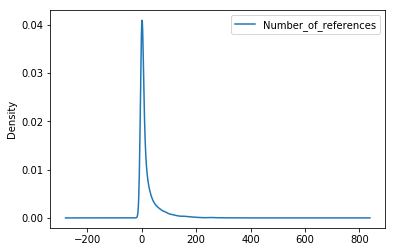

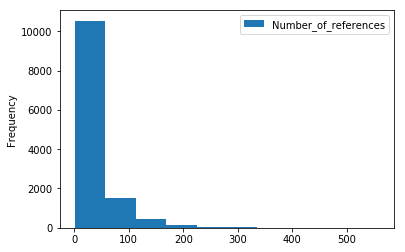

In [41]:
df.plot(kind='kde');
df[df.Number_of_references>0].plot(kind='hist');


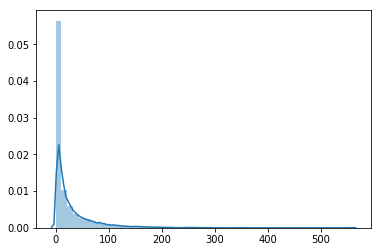

In [21]:
sns.distplot(df );

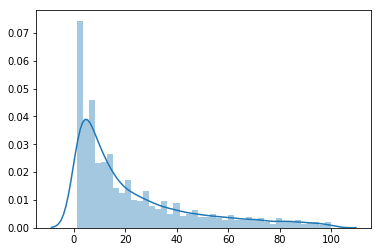

In [43]:


sns.distplot(df.query("Number_of_references >0 and Number_of_references <=100") );

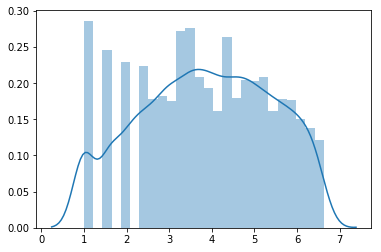

In [32]:
sns.distplot(np.log2(df.query("Number_of_references >1 and Number_of_references <100") ));

In [28]:
!bzip2 --help


bzip2, a block-sorting file compressor.  Version 1.0.6, 6-Sept-2010.

   usage: bzip2 [flags and input files in any order]

   -h --help           print this message
   -d --decompress     force decompression
   -z --compress       force compression
   -k --keep           keep (don't delete) input files
   -f --force          overwrite existing output files
   -t --test           test compressed file integrity
   -c --stdout         output to standard out
   -q --quiet          suppress noncritical error messages
   -v --verbose        be verbose (a 2nd -v gives more)
   -L --license        display software version & license
   -V --version        display software version & license
   -s --small          use less memory (at most 2500k)
   -1 .. -9            set block size to 100k .. 900k
   --fast              alias for -1
   --best              alias for -9

   If invoked as `bzip2', default action is to compress.
              as `bunzip2',  default action is to decompress.
        